# Imports and Configurations

In [1]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tqdm import tqdm
from util.StringObjectParser import StringObjectParser
import scipy.stats as stats



In [2]:
sns.set_theme(style="whitegrid")

# Load Data

## NL to SQL Performance

In [3]:
current_directory = os.getcwd()
print(f"The current working directory is: {current_directory}")
data_directory = current_directory.replace("/src", "/nl_sql_results/token_count_added")

xlsx_files = [file for file in os.listdir(data_directory) if file.endswith(".xlsx")]
dataframes = []
for xf in xlsx_files:
    df = pd.read_excel(os.path.join(data_directory, xf))
    xf_bits = xf.split("-")
    df["subsetting_method"] = xf_bits[1]
    df["benchmark"] = xf_bits[2]
    df["comments"] = xf_bits[4].replace(".xlsx", "")
    dataframes.append(df)
nlsql_performance_df = pd.concat(dataframes, ignore_index=True)

The current working directory is: /data/kluoma/skalpel-subsetting-evaluation/src


## Subsetting Performance

In [4]:
current_directory = os.getcwd()
print(f"The current working directory is: {current_directory}")
data_directory = current_directory.replace("/src", "/subsetting_results")

xlsx_files = [file for file in os.listdir(data_directory) if file.endswith('.xlsx')]
dataframes = []
for xf in xlsx_files:
    df = pd.read_excel(os.path.join(data_directory, xf))
    df["subsetting_method"] = xf.split("-")[1]
    df["benchmark"] = xf.split("-")[2]
    df["comments"] = xf.split("-")[4].replace(".xlsx", "")
    dataframes.append(df)
subset_performance_df = pd.concat(dataframes, ignore_index=True)
for column in subset_performance_df.columns:
    processed_objs = []
    for val in subset_performance_df[column]:
        obj = StringObjectParser.string_to_python_object(val, use_eval=True)
        if type(obj) == str and len(obj) > 0 and obj[0] == "{":
            obj = set([v.strip() for v in obj.replace("{", "").replace("}", "").split(",")])
        processed_objs.append(obj)
    subset_performance_df[column] = processed_objs
        # subset_performance_df[column] = subset_performance_df[column].apply(
        #     lambda x: StringObjectParser.string_to_python_object(x, use_eval=True) if StringObjectParser.check_valid_container(x) or x == "set()" else x
        # )
    

The current working directory is: /data/kluoma/skalpel-subsetting-evaluation/src


/data/kluoma/skalpel-subsetting-evaluation/src/util/StringObjectParser.py:58: UserWarning: Using eval can be dangerous. Make sure the input string is from a trusted source.
  warnings.warn("Using eval can be dangerous. Make sure the input string is from a trusted source.")


## Schema Stats

In [5]:
current_directory = f"{os.getcwd()}/benchmark_schema_stats"
data_directory = current_directory.replace("/src", "/subsetting_results")

json_files = [file for file in os.listdir(data_directory) if file.endswith('_stats.json')]
df_dict = {"benchmark": [], "database": [], "table_count": [], "column_count": []}
for filename in json_files:
    fn_split = filename.split("_")
    stat_dict = json.loads(open(f"{data_directory}/{filename}", "r").read())
    for k in stat_dict:
        df_dict["benchmark"].append(fn_split[0])
        df_dict["database"].append(k)
        df_dict["table_count"].append(stat_dict[k]["table_count"])
        df_dict["column_count"].append(stat_dict[k]["column_count"])
schema_stat_df = pd.DataFrame(df_dict).query("benchmark!='abstract'")
for column in schema_stat_df.columns:
    schema_stat_df[column] = schema_stat_df[column].apply(
        lambda x: StringObjectParser.string_to_python_object(x, use_eval=True) if StringObjectParser.check_valid_container(x) or x == "set()" else x
    )

# Process Data

## Model Filter

In [6]:
comment_model_filter = {
    "CodeS": "lambda1_sic_merged",
    "DINSQL": "gpt41",
    "chess": "gpt4o",
    "crush4sql": "lambda1",
    "dtssql": "lambda1",
    "rslsql": "gpt41",
    "tasql": "gpt41",
    "skalpel": "vector_qdecomp_525th",
    # "skalpel": "do not eval",
    "skalpeltasql": "gpt41nano-vectorsort",
    "perfect_subsetter": "oracle",
    "perfect_table_subsetter": "oracle",
    "nosubset": "fullschema"
}

## NL SQL Model Categories

In [7]:
nl_sql_model_categories = {
    "openai/gpt-oss-120b": "Open", 
    "llama3.3": "Open", 
    "gemini-2.5-pro": "Flagship",
    "gemini-2.0-flash-lite-001": "Economy", 
    "gemini-2.0-flash-001": "Economy",
    "gpt-4.1-nano": "Economy", 
    "gpt-4.1": "Flagship"
}

## Display Data Maps

In [8]:
subsetting_display_names = {
    "crush4sql": "Crush",
    "rslsql": "RSLSQL",
    "tasql": "TASQL",
    "CodeS": "CodeS",
    "dtssql": "DTSSQL",
    "chess": "CHESS",
    "DINSQL": "DINSQL",
    "skalpel": "Skalpel",
    "skalpeltasql": "Skalpel+TASQL",
    "perfect_subsetter": "Perfect",
    "perfect_table_subsetter": "Perfect-Table",
    "nosubset": "FullSchema"
}

In [9]:
subsetting_classifications = {
    "crush4sql": "Hyb",
    "rslsql": "LLM",
    "tasql": "LLM",
    "CodeS": "ML",
    "dtssql": "LLM",
    "chess": "Hyb",
    "DINSQL": "LLM",
    "Skalpel": "Hyb",
    "Skalpel+TASQL": "Hyb",
    "perfect_subsetter": "Oracle",
    "perfect_table_subsetter": "Oracle",
    "nosubset": "Full"
}

In [10]:
subsetting_display_order = {
    "Crush": 80,
    "RSLSQL": 40,
    "TASQL": 50,
    "CodeS": 90,
    "DTSSQL": 100,
    "CHESS": 70,
    "DINSQL": 60,
    "Skalpel": 30,
    "Skalpel+TASQL": 35,
    "Perfect": 10,
    "Perfect-Table": 20,
    "FullSchema": 1000
}

## Process Performance Data

In [11]:
nlsql_performance_df["Subsetting Method"] = nlsql_performance_df.subsetting_method.apply(lambda x: subsetting_display_names[x])
subset_performance_df["Subsetting Method"] = subset_performance_df.subsetting_method.apply(lambda x: subsetting_display_names[x])

In [12]:
nlsql_performance_df["nl_sql_model_cat"] = nlsql_performance_df.nl_sql_model.apply(lambda x: nl_sql_model_categories[x])

In [13]:
nlsql_performance_df["eval_model"] = nlsql_performance_df.apply(
    lambda row: row.comments == comment_model_filter[row.subsetting_method], 
    axis=1
    )
subset_performance_df["eval_model"] = subset_performance_df.apply(
    lambda row: row.comments == comment_model_filter[row.subsetting_method], 
    axis=1
    )
nlsql_performance_df["nl_sql_model"] = nlsql_performance_df.nl_sql_model.fillna("openai/gpt-oss-120b")

In [14]:
nlsql_performance_df["method_order"] = nlsql_performance_df["Subsetting Method"].apply(
    lambda x: subsetting_display_order[x]
    )
nlsql_performance_df["has_generated_query"] = nlsql_performance_df.generated_query.fillna("doh").apply(lambda x: x != "doh" and x != 'Token limited exceeded')

In [15]:
subset_performance_df["perfect_recall"] = subset_performance_df.total_recall.apply(lambda x: 1 if x == 1.0 else 0)
subset_performance_df["empty_subset"] = subset_performance_df.apply(
    lambda row: len(row.correct_tables)==0 and len(row.extra_tables)==0,
    axis=1
    )
subset_performance_df["subset_table_count"] = subset_performance_df.apply(lambda row: len(row.correct_tables) + len(row.extra_tables), axis=1)
subset_performance_df["subset_column_count"] = subset_performance_df.apply(lambda row: len(row.correct_columns) + len(row.extra_columns), axis=1)

In [16]:
from NlSqlBenchmark.NlSqlBenchmarkFactory import NlSqlBenchmarkFactory
from NlSqlBenchmark.SchemaObjects import Schema
from SchemaSubsetter.Perfect.PerfectSchemaSubsetter import PerfectSchemaSubsetter
from SubsetEvaluator.SchemaSubsetEvaluator import SchemaSubsetEvaluator, SubsetEvaluation
import os
from tqdm import tqdm
current_directory = os.getcwd()
os.chdir(current_directory.replace("/src", "/"))
fact = NlSqlBenchmarkFactory()

fullschema_dfs = []

for bm_name in ["snails", "bird", "spider2"]:
    bm = fact.build_benchmark(bm_name)
    evaluator = SchemaSubsetEvaluator(use_result_cache=True)
    bm_data = {
        "database": [],
        "question_number": [],
        "total_precision": [],
        "total_f1": [],
        "table_recall": [],
        "table_precision": [],
        "table_f1": [],
        "column_recall": [],
        "column_f1": [],
        "subset_table_proportion": [],
        "subset_column_proportion": [],
        "subsetting_method": [],
        "benchmark": [],
        "comments": [],
        "eval_model": [],
        "perfect_recall": [],
        "empty_subset": [],
        "subset_table_count": [],
        "subset_column_count": []
    }
    for question in tqdm(bm):
        bm_data["database"].append(question.schema.database)
        bm_data["question_number"].append(question.question_number)
        evaluation = evaluator.evaluate_schema_subset(question.schema, question)
        bm_data["total_precision"].append(evaluation.total_precision)
        bm_data["total_f1"].append(evaluation.total_f1)
        bm_data["table_recall"].append(evaluation.table_recall)
        bm_data["table_precision"].append(evaluation.table_precision)
        bm_data["table_f1"].append(evaluation.table_f1)
        bm_data["column_recall"].append(evaluation.column_recall)
        bm_data["column_f1"].append(evaluation.column_f1)
        bm_data["subset_table_proportion"].append(evaluation.subset_table_proportion)
        bm_data["subset_column_proportion"].append(evaluation.subset_column_proportion)
        bm_data["subsetting_method"].append("nosubset")
        bm_data["benchmark"].append(bm_name)
        bm_data["comments"].append("FullSchema")
        bm_data["eval_model"].append(True)
        bm_data["perfect_recall"].append(1 if evaluation.total_recall == 1.0 else 0)
        bm_data["empty_subset"].append(len(question.schema.tables) == 0 and question.schema.get_column_count() == 0)
        bm_data["subset_table_count"].append(len(question.schema.tables))
        bm_data["subset_column_count"].append(question.schema.get_column_count())

    fullschema_dfs.append(pd.DataFrame(bm_data))
os.chdir(current_directory)
subset_performance_df = pd.concat([subset_performance_df.query("subsetting_method != 'nosubset'")] + fullschema_dfs)

NlSqlBenchmark.NlSqlBenchmarkFactory


/data/kluoma/skalpel-subsetting-evaluation/venv/lib/python3.10/site-packages/snowflake/connector/options.py:108: UserWarning: You have an incompatible version of 'pyarrow' installed (19.0.1), please install a version that adheres to: 'pyarrow<19.0.0; extra == "pandas"'
  warn_incompatible_dep(
100%|██████████| 221/221 [00:05<00:00, 41.97it/s]


## Process Schema Stat Data

In [17]:
schema_sizes = {
    # 100: "s",
    1000: "S-M",
    100000: "L-XL-XXL",
    # 50000: "xl",
    # 100000: "xxl"
}

schema_sizes_expanded = {
    100: "s",
    1000: "m",
    2500: "l",
    50000: "xl",
    100000: "xxl"
}

def get_size(x: int, size_lookup: dict = None) -> str:
    for s in size_lookup.keys():
        if x < s:
            return size_lookup[s]

schema_size_map = {
    schema_sizes[k] : k for k in schema_sizes.keys()
}

schema_size_map_expanded = {
    schema_sizes_expanded[k] : k for k in schema_sizes_expanded.keys()
}

schema_stat_df["size_cat"] = schema_stat_df.column_count.apply(
    lambda x: get_size(x, schema_sizes) 
    )
schema_stat_df["size_cat_expanded"] = schema_stat_df.column_count.apply(
    lambda x: get_size(x, schema_sizes_expanded)
)
schema_stat_df["size_descr"] = schema_stat_df.size_cat.apply(
    lambda x: f"col<{schema_size_map[x]:,}"
)
schema_stat_df["size_sort"] = schema_stat_df.size_cat.apply(
    lambda x: schema_size_map[x]
)

schema_stat_df["size_sort_expanded"] = schema_stat_df.size_cat_expanded.apply(
    lambda x: schema_size_map_expanded[x]
)

schema_stat_df["mean_table_size"] = schema_stat_df.apply(
    lambda row: row.column_count / row.table_count,
    axis=1
)

# Failed NL to SQL

In [18]:
join_index = ["subsetting_method", "benchmark", "database", "question_number"]
temp_data_df = nlsql_performance_df.set_index(join_index).join(
    subset_performance_df.set_index(join_index),
    lsuffix="_l", rsuffix="_r"
).reset_index()
temp_data_df["generated_query"] = temp_data_df.generated_query.fillna("no query")
temp_data_df.query(
    "eval_model_l and (generated_query=='Token limited exceeded' or generated_query=='no query') and empty_subset==False"
    )[["nl_sql_model", "subsetting_method", "database", "gold_query"]].groupby([
    "nl_sql_model", "subsetting_method", "database"
]).count()


gold_query
nl_sql_model         subsetting_method database                                  
gemini-2.0-flash-001 skalpel           CratersWildlifeObservations              5
                                       KlamathInvasiveSpecies                  15
                                       NTSB                                    55
                                       NorthernPlainsFireManagement             5
                                       PATENTS                                  1
...                                                                           ...
openai/gpt-oss-120b  nosubset          fhir_synthea                             1
                                       gnomAD                                   2
                                       google_dei                               1
                                       sdoh                                     7
                     tasql             ASIS_20161108_HerpInv_Database           1

[158 rows x 1 columns]

# Execution Accuracy for Each Subsetting Method

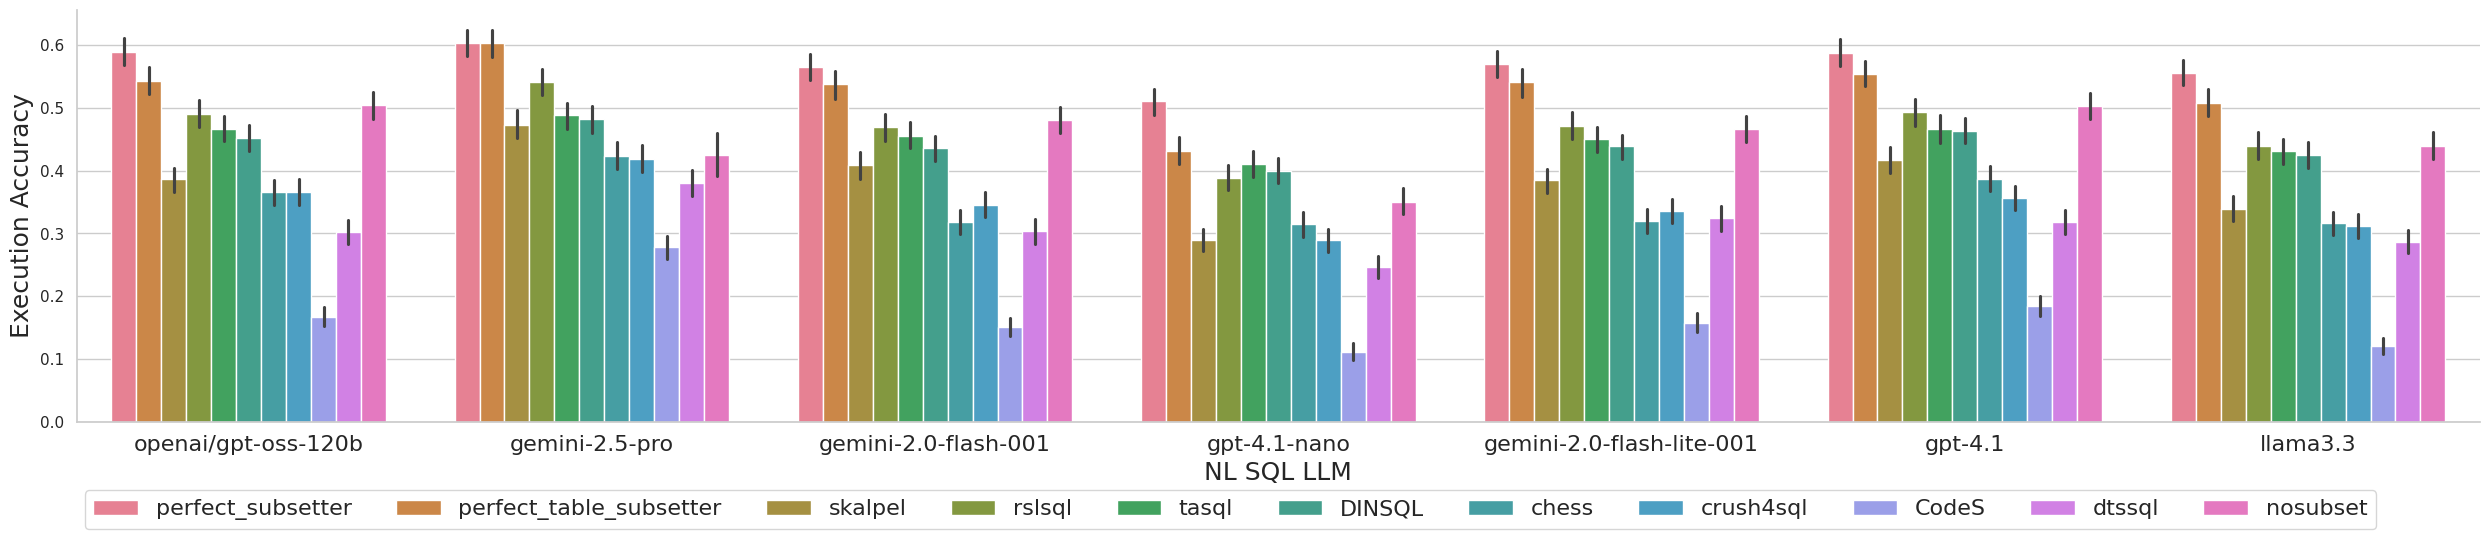

In [19]:
g = sns.catplot(
    data=nlsql_performance_df.query("eval_model and has_generated_query").set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
    ).sort_values(by=["method_order", "size_sort"]),
    x="nl_sql_model",
    y="result_set_match",
    kind="bar",
    hue="subsetting_method",
    aspect=5,
    # col="size_cat",
    # col_wrap=1,
    legend_out=False,
    # legend=False
)
plt.legend(bbox_to_anchor=(0.48, -0.26), loc='lower center', borderaxespad=0, ncols=11, fontsize=16)
g.set_axis_labels("NL SQL LLM", "Execution Accuracy", fontsize=18)
g.set_xticklabels(fontsize=16)
g.set_axis_labels("NL SQL LLM", "Execution Accuracy")
g.figure.savefig("../nl_sql_results/figures/nlsql_execution_accuracy_barchart.pdf", bbox_inches="tight", dpi=300)

## Execution accuracy by benchmark, LLM, and subsetting method

In [20]:
nlsql_performance_df.nl_sql_model.unique()

array(['openai/gpt-oss-120b', 'gemini-2.5-pro', 'llama3.3',
       'gemini-2.0-flash-lite-001', 'gemini-2.0-flash-001',
       'gpt-4.1-nano', 'gpt-4.1'], dtype=object)

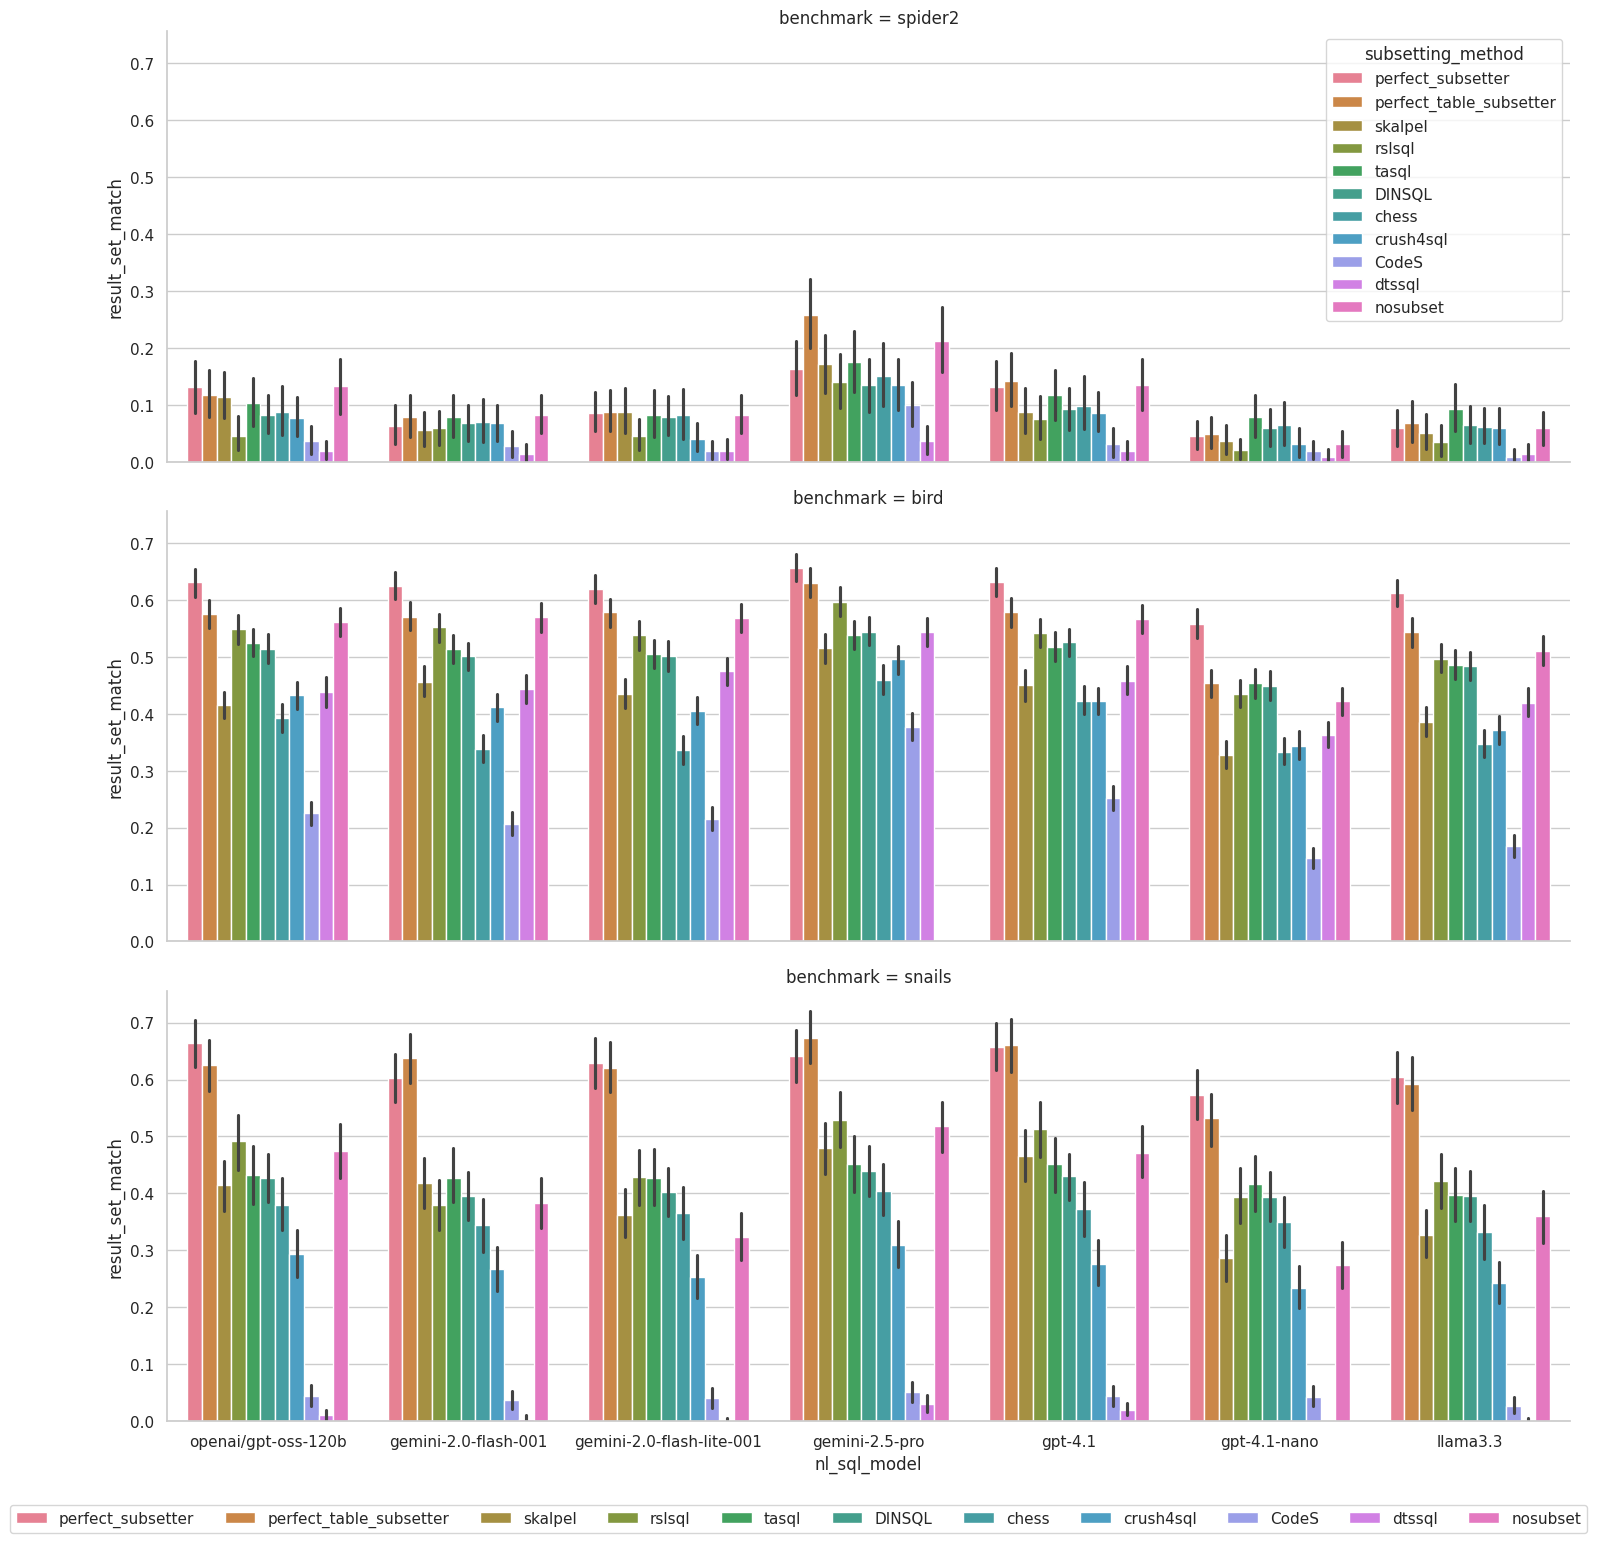

In [21]:
g = sns.catplot(
    data=nlsql_performance_df.query("eval_model and has_generated_query").sort_values(by="method_order"),
    x="nl_sql_model",
    y="result_set_match",
    kind="bar",
    hue="subsetting_method",
    aspect=3,
    col="benchmark",
    col_wrap=1,
    legend_out=False,
    # legend=False
)
plt.legend(bbox_to_anchor=(0.45, -0.26), loc='lower center', borderaxespad=0, ncols=11)




## Execution Accuracy by Benchmark, LLM, and Database Size 

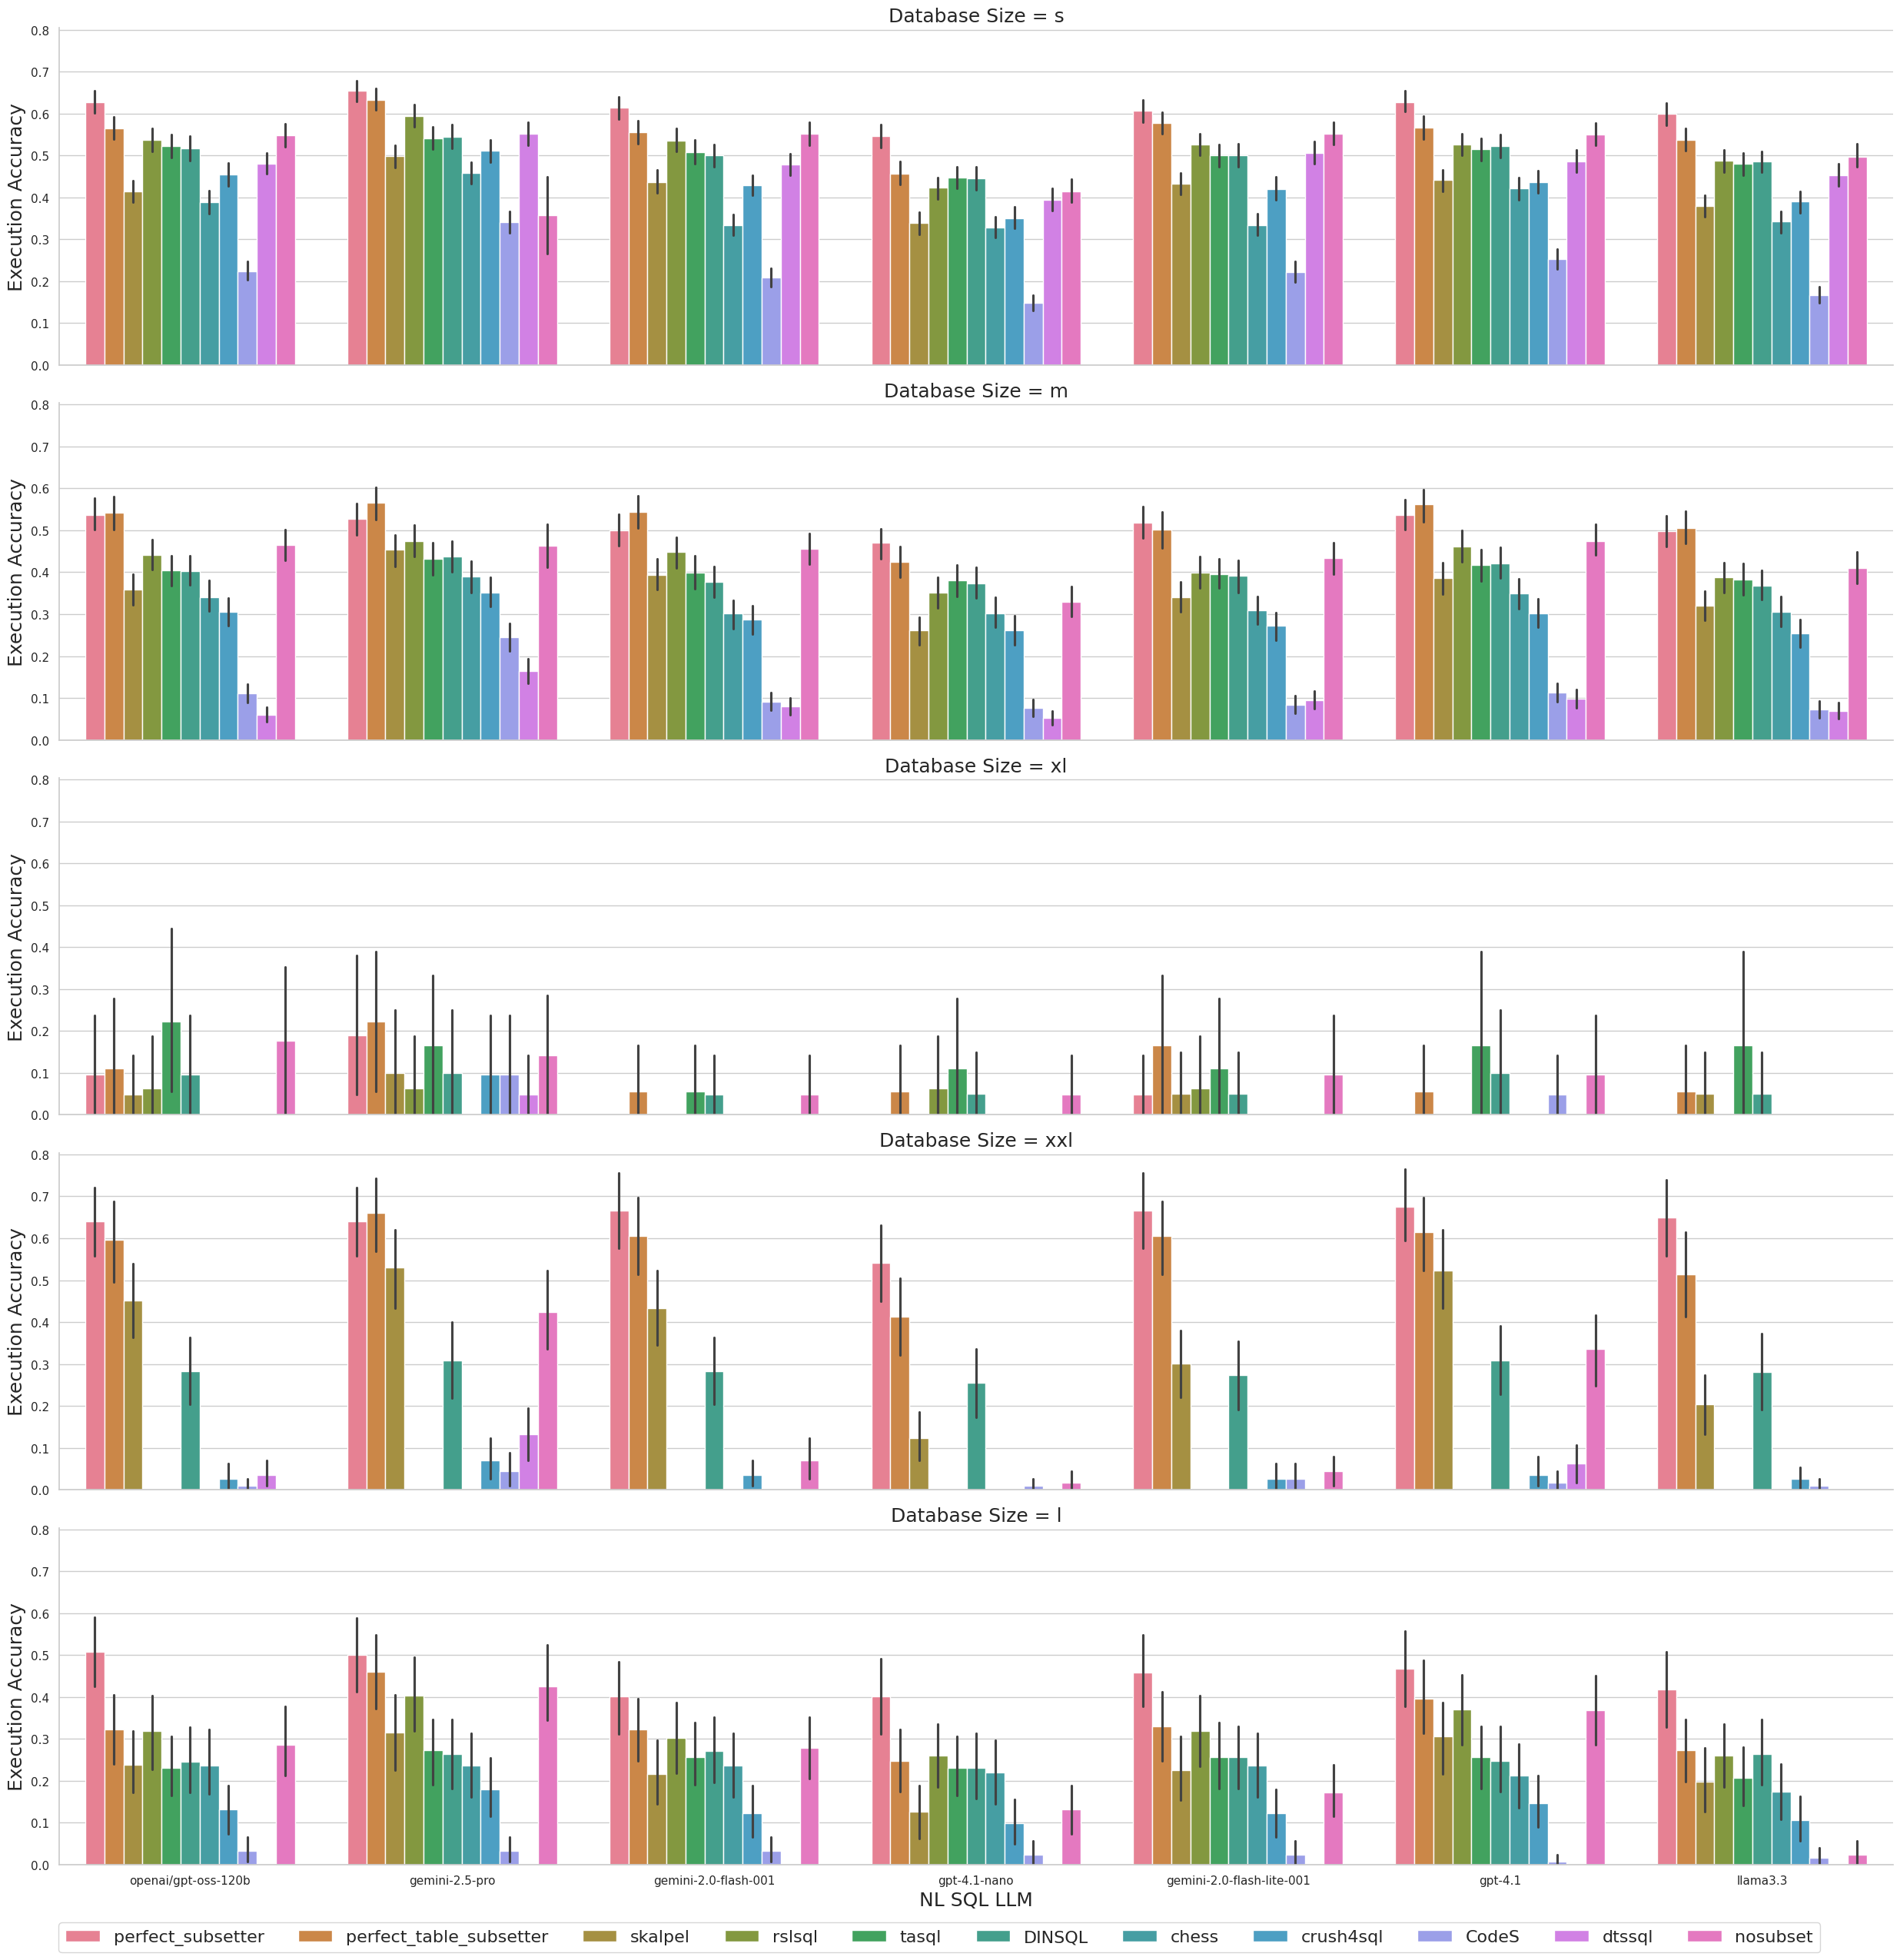

In [22]:
g = sns.catplot(
    data=nlsql_performance_df.query("eval_model and has_generated_query").set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
    ).sort_values(by=["method_order", "size_sort"]),
    x="nl_sql_model",
    y="result_set_match",
    kind="bar",
    hue="subsetting_method",
    aspect=5,
    col="size_cat_expanded",
    col_wrap=1,
    legend_out=True,
    # legend=False
)

plt.legend(bbox_to_anchor=(0.48, -0.26), loc='lower center', borderaxespad=0, ncols=11, fontsize=16)
g._legend.remove()
g.set_axis_labels("NL SQL LLM", "Execution Accuracy", fontsize=18)
for ax in g.axes.flat:    
    ax.set_title(ax.get_title().replace("size_cat_expanded", "Database Size"), fontsize=18)

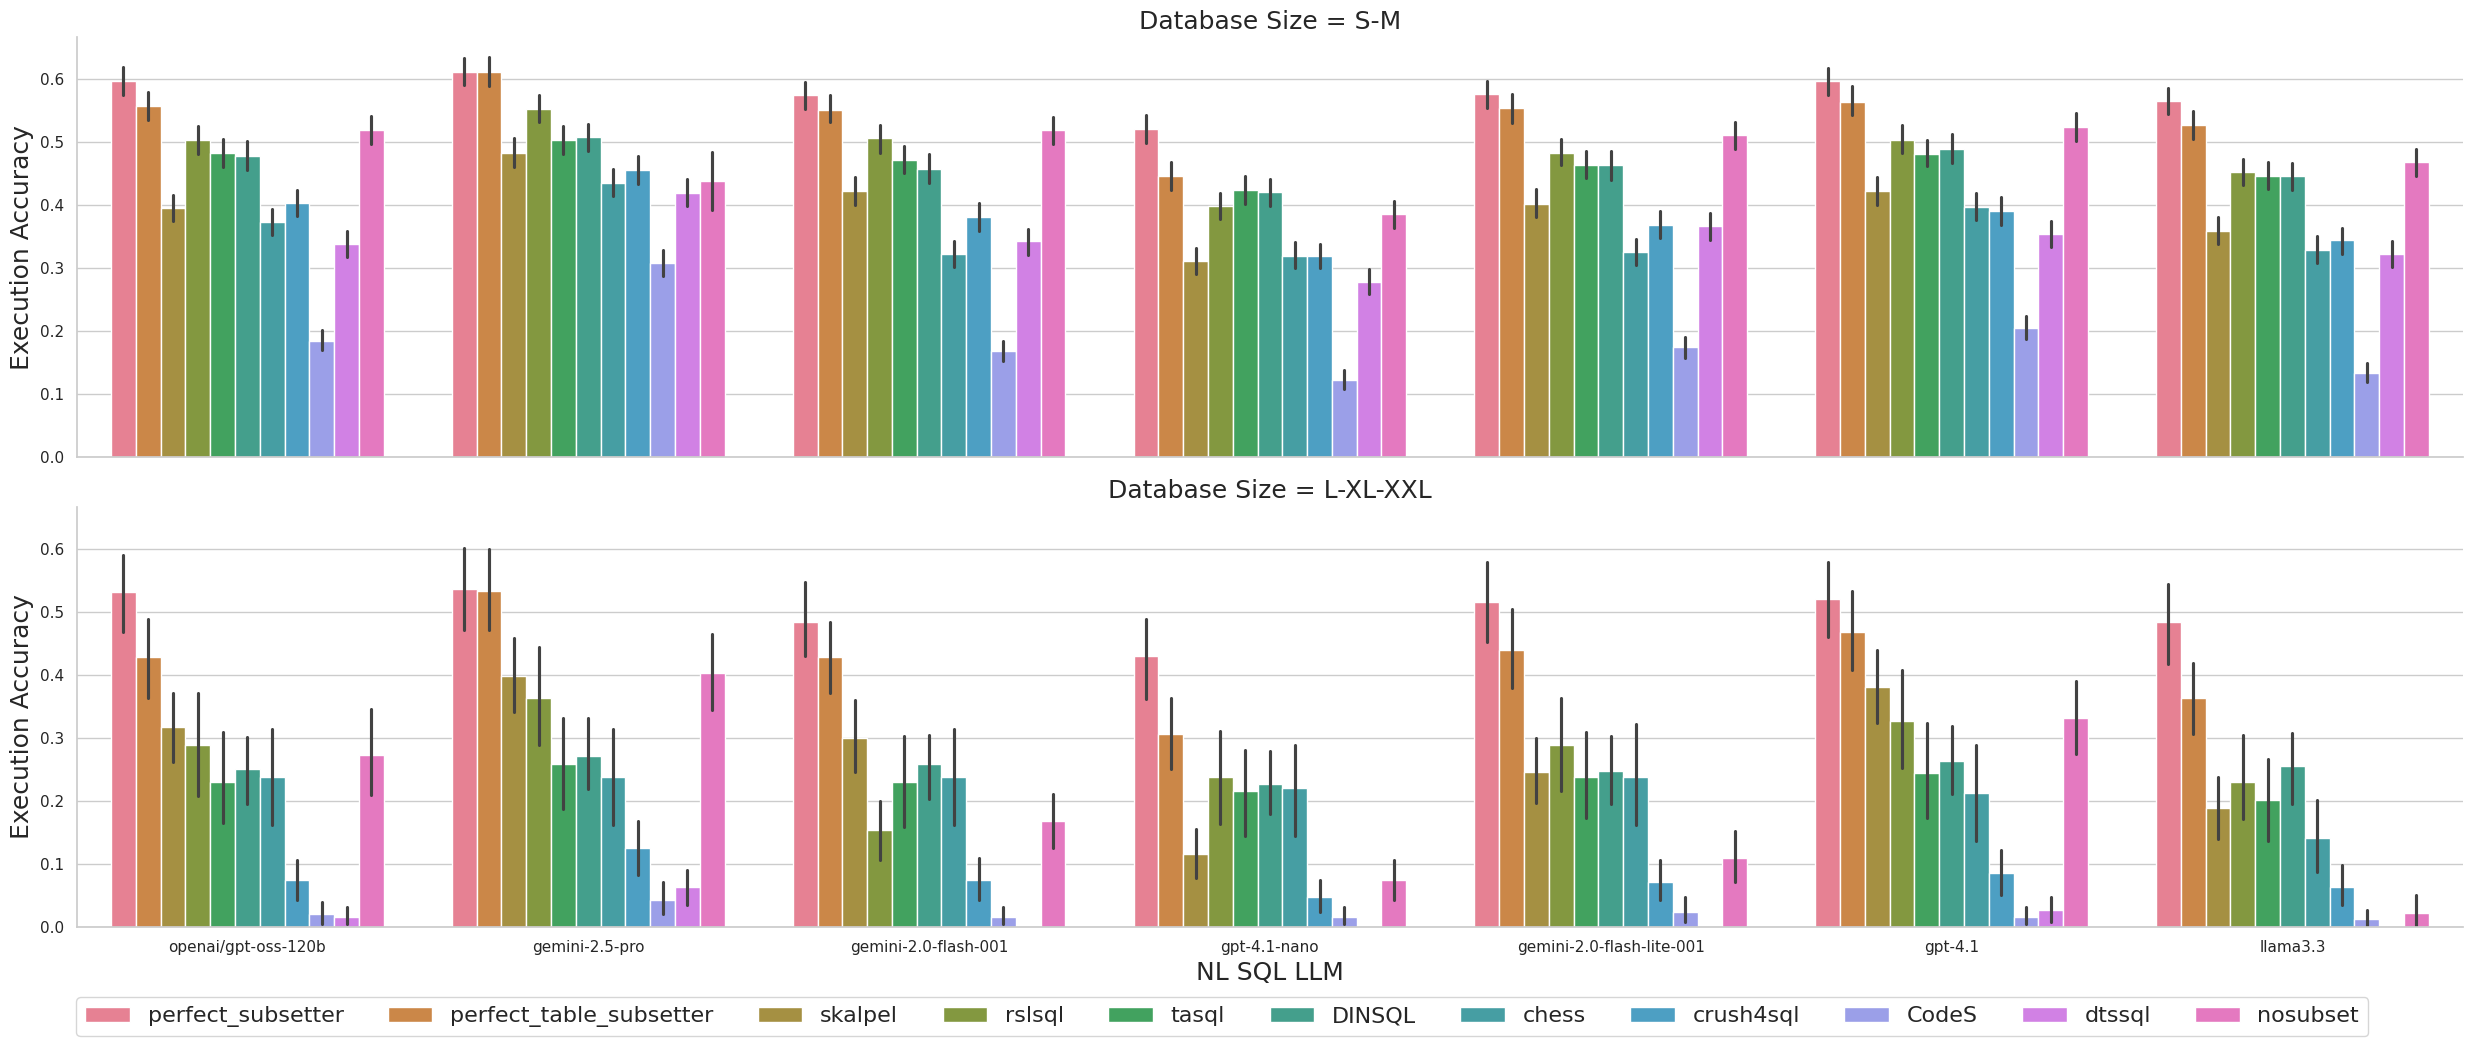

In [23]:
g = sns.catplot(
    data=nlsql_performance_df.query("eval_model and has_generated_query").set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
    ).sort_values(by=["method_order", "size_sort"]),
    x="nl_sql_model",
    y="result_set_match",
    kind="bar",
    hue="subsetting_method",
    aspect=5,
    col="size_cat",
    col_wrap=1,
    legend_out=True,
    # legend=False
)

plt.legend(bbox_to_anchor=(0.48, -0.26), loc='lower center', borderaxespad=0, ncols=11, fontsize=16)
g._legend.remove()
g.set_axis_labels("NL SQL LLM", "Execution Accuracy", fontsize=18)
for ax in g.axes.flat:    
    ax.set_title(ax.get_title().replace("size_cat", "Database Size"), fontsize=18)
g.figure.savefig("../nl_sql_results/figures/nlsql_execution_accuracy_barchart_sizes.pdf", bbox_inches="tight", dpi=300)


# Subsetting - NlSQL Performance Correlations

In [24]:
temp_data_df = subset_performance_df.set_index(
    ["subsetting_method", "benchmark", "database", "question_number"]
    ).join(
        nlsql_performance_df.set_index(
        ["subsetting_method", "benchmark", "database", "question_number"]
        ),
        lsuffix="l_", rsuffix="r_"
    ).reset_index().set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
    ).reset_index()

## Recall x Execution Accuracy

<Axes: xlabel='total_recall', ylabel='result_set_match'>

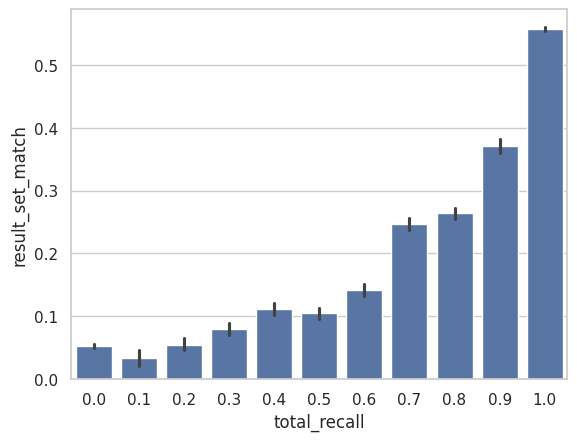

In [25]:
temp_data_df = subset_performance_df.set_index(
    ["subsetting_method", "benchmark", "database", "question_number"]
    ).join(
        nlsql_performance_df.set_index(
        ["subsetting_method", "benchmark", "database", "question_number"]
        ),
        lsuffix="_l", rsuffix="_r"
    ).reset_index().set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
    ).reset_index().query("eval_model_l")
sns.barplot(
    data=temp_data_df,
    x=temp_data_df.total_recall.round(1),
    y="result_set_match"
)

## Precision x Execution Accuracy

<Axes: xlabel='total_precision', ylabel='result_set_match'>

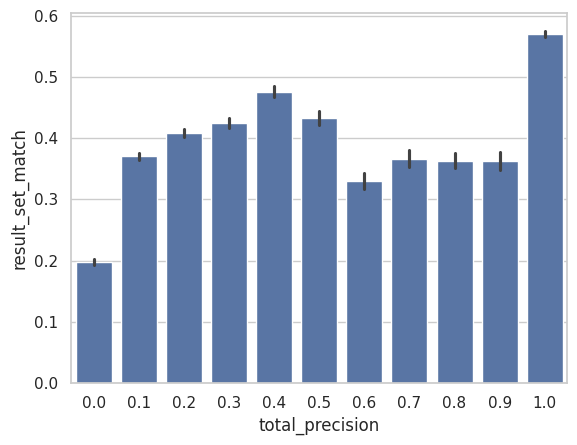

In [26]:
temp_data_df = subset_performance_df.set_index(
    ["subsetting_method", "benchmark", "database", "question_number"]
    ).join(
        nlsql_performance_df.set_index(
        ["subsetting_method", "benchmark", "database", "question_number"]
        ),
        lsuffix="_l", rsuffix="_r"
    ).reset_index().set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
    ).reset_index().query("eval_model_l and has_generated_query")
sns.barplot(
    data=temp_data_df,
    x=temp_data_df.total_precision.round(1),
    y="result_set_match"
)

## Table proportion x Execution Accuracy

<Axes: xlabel='subset_table_proportion', ylabel='result_set_match'>

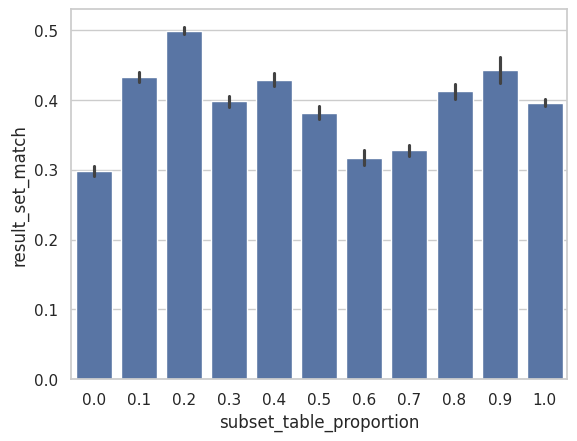

In [27]:
temp_data_df = subset_performance_df.set_index(
    ["subsetting_method", "benchmark", "database", "question_number"]
    ).join(
        nlsql_performance_df.set_index(
        ["subsetting_method", "benchmark", "database", "question_number"]
        ),
        lsuffix="_l", rsuffix="_r"
    ).reset_index().set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
    ).reset_index()
sns.barplot(
    data=temp_data_df.query("subset_table_proportion <= 1"),
    x=temp_data_df.query("subset_table_proportion <= 1 and eval_model_l and has_generated_query").subset_table_proportion.round(1),
    y="result_set_match"
)

## Subset Column count x Execution Accuracy

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79],
 [Text(0, 0, '0.0'),
  Text(1, 0, '0.7'),
  Text(2, 0, '1.1'),
  Text(3, 0, '1.4'),
  Text(4, 0, '1.6'),
  Text(5, 0, '1.8'),
  Text(6, 0, '1.9'),
  Text(7, 0, '2.1'),
  Text(8, 0, '2.2'),
  Text(9, 0, '2.3'),
  Text(10, 0, '2.4'),
  Text(11, 0, '2.5'),
  Text(12, 0, '2.6'),
  Text(13, 0, '2.7'),
  Text(14, 0, '2.8'),
  Text(15, 0, '2.9'),
  Text(16, 0, '3.0'),
  Text(17, 0, '3.1'),
  Text(18, 0, '3.2'),
  Text(19, 0, '3.3'),
  Text(20, 0, '3.4'),
  Text(21, 0, '3.5'),
  Text(22, 0, '3.6'),
  Text(23, 0, '3.7'),
  Text(24, 

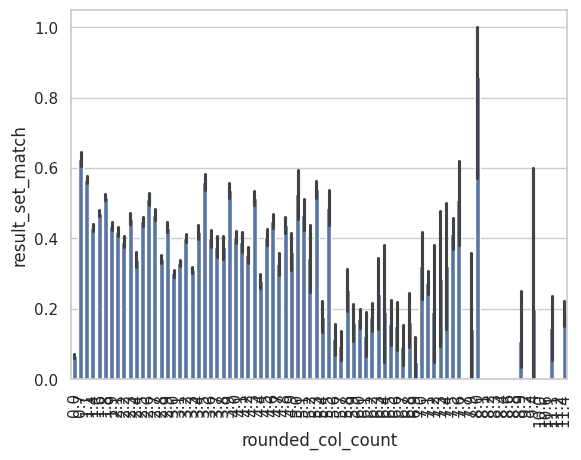

In [28]:
temp_data_df = subset_performance_df.set_index(
    ["subsetting_method", "benchmark", "database", "question_number"]
    ).join(
        nlsql_performance_df.set_index(
        ["subsetting_method", "benchmark", "database", "question_number"]
        ),
        lsuffix="_l", rsuffix="_r"
    ).reset_index().set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
    ).reset_index()
temp_data_df["rounded_col_count"] = temp_data_df.subset_column_count.apply(lambda x: round(np.log1p(x), 1))
sns.barplot(
    data=temp_data_df.query("eval_model_l and has_generated_query"),
    x="rounded_col_count",
    y="result_set_match"
)
plt.xticks(rotation=90)

## Bar plot of schema column count x execution accuracy for all methods

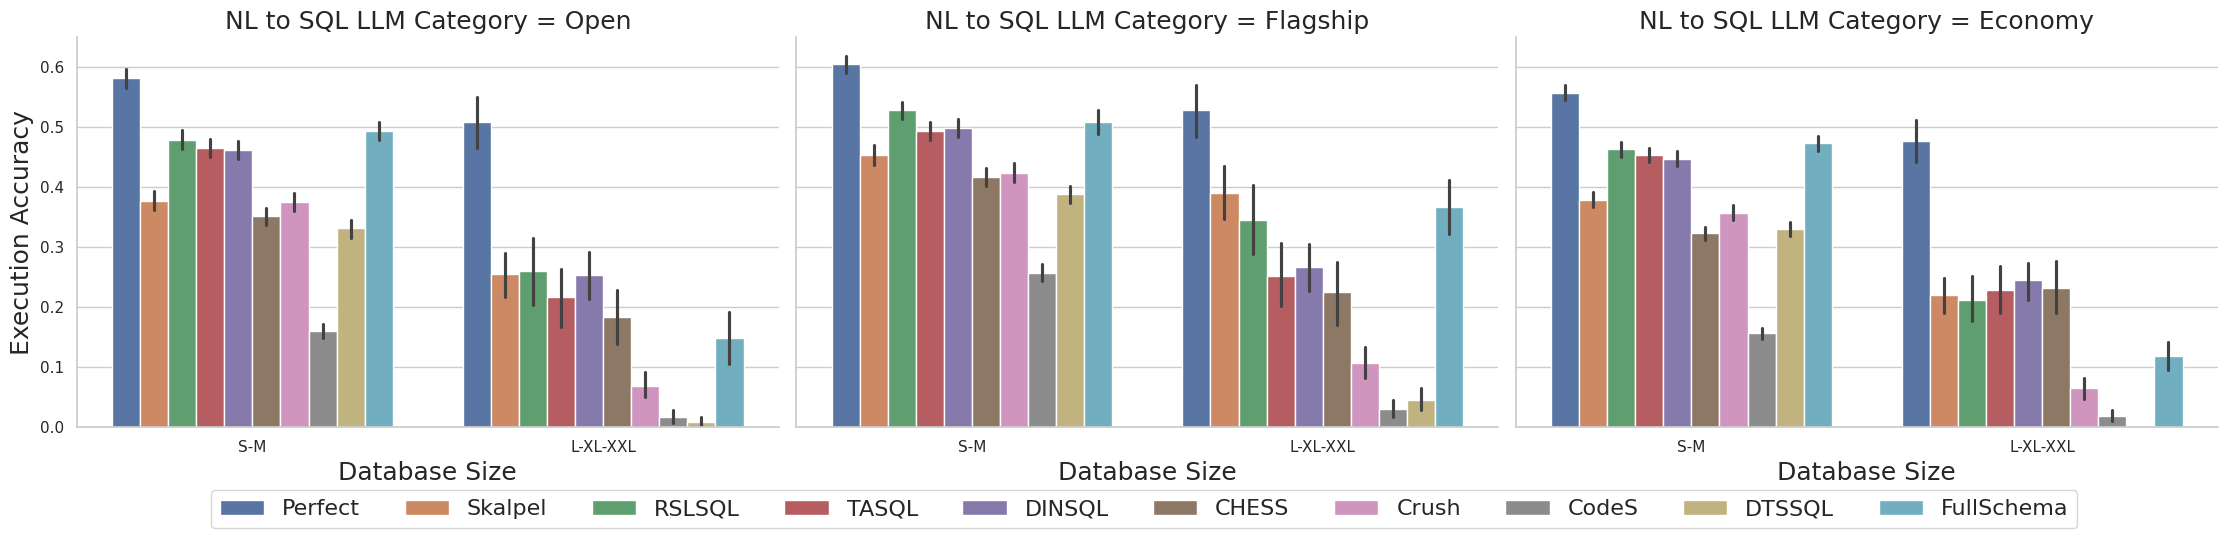

In [29]:
temp_data_df = subset_performance_df.set_index(
    ["subsetting_method", "benchmark", "database", "question_number"]
    ).join(
        nlsql_performance_df.set_index(
        ["subsetting_method", "benchmark", "database", "question_number"]
        ),
        lsuffix="_l", rsuffix="_r"
    ).reset_index().set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
    ).reset_index()
g = sns.catplot(
    data=temp_data_df.query(
        "eval_model_l and (subsetting_method not in ['perfect_table_subsetter']) and has_generated_query"
        ).sort_values(by=["method_order", "size_sort_expanded"]).drop("Subsetting Method_l", axis=1).rename(columns={
            "Subsetting Method_r": "Subsetting Method"
        }),
    x="size_cat",
    y="result_set_match",
    hue="Subsetting Method",
    kind="bar",
    col="nl_sql_model_cat",
    col_wrap=3,
    aspect=1.5
)
plt.legend(bbox_to_anchor=(0.8, -0.26), loc='lower right', borderaxespad=0, ncols=11, fontsize=16)
g._legend.remove()
g.set_axis_labels("Database Size", "Execution Accuracy", fontsize=18)
for ax in g.axes.flat:    
    ax.set_title(ax.get_title().replace("nl_sql_model_cat", "NL to SQL LLM Category"), fontsize=18) 
g.figure.savefig("../nl_sql_results/figures/nlsql_execution_accuracy_barchart_compact.pdf", bbox_inches="tight", dpi=300)



In [30]:
temp_data_df.size_cat_expanded.unique()

array(['m', 's', 'l', 'xxl', 'xl'], dtype=object)

## Logistic Regression

### All subsetting metrics predict execution accuracy

In [31]:
temp_data_df.subsetting_method.unique()

array(['skalpel', 'crush4sql', 'rslsql', 'dtssql', 'CodeS', 'tasql',
       'perfect_subsetter', 'perfect_table_subsetter', 'chess',
       'skalpeltasql', 'DINSQL', 'nosubset'], dtype=object)

In [34]:
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

temp_data_df = subset_performance_df.set_index(
    ["subsetting_method", "benchmark", "database", "question_number"]
    ).join(
        nlsql_performance_df.set_index(
        ["subsetting_method", "benchmark", "database", "question_number"]
        ),
        lsuffix="_l", rsuffix="_r"
    ).reset_index().set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
    ).reset_index().query(
        "eval_model_l and has_generated_query and subsetting_method not in ['perfect_subsetter', 'perfect_table_subsetter', 'nosubset']"
        ).dropna()
temp_data_df['result_set_match_numeric'] = temp_data_df['result_set_match'].astype(int)
temp_data_df["schema_size_numeric"] = temp_data_df.size_cat.apply(lambda x: {
    "s": 1,
    "S": 1,
    "m": 2,
    "M": 2,
    "s-m": 1.5,
    "S-M": 1.5,
    "l": 3,
    "L": 3,
    "l+": 3,
    "L+": 3,
    "xl": 4,
    "XL": 4,
    "xxl": 5,
    "XXL": 5,
    "L-XL-XXL": 4
}[x])
temp_data_df["LogSchemaColumnCount"] = temp_data_df.column_count.apply(lambda x: np.log1p(x))
scaler = StandardScaler()
temp_data_df["LogSchemaColumnCount"] = scaler.fit_transform(temp_data_df[["LogSchemaColumnCount"]])

X = temp_data_df[[
    # "perfect_recall",
    # "total_recall",
    # "total_precision",
    # "total_f1",
    "table_recall",
    "table_precision",
    # "table_f1",
    "column_recall",
    "column_precision",
    # "column_f1",
    "subset_table_proportion",
    "subset_column_proportion",
    # "subset_table_count",
    # "subset_column_count",
    # "schema_size_numeric",
    # "column_count",
    # "rounded_schema_col_count",
    # "LogSchemaColumnCount"
    ]]
y = temp_data_df['result_set_match_numeric']
X = sm.add_constant(X)
logit_model = sm.Logit(y, X).fit()

coef_df = pd.DataFrame({
    "Coef": logit_model.params,
    "StdErr": logit_model.bse,
    "pValue": logit_model.pvalues
})
coef_df = coef_df.reset_index(names=["Metric"])
coef_df["Metric"] = coef_df.Metric.apply(lambda x: {
    "const": "Const",
    "table_recall": "TableRecall",
    "table_precision": "TablePrecision",
    "column_recall": "ColumnRecall",
    "column_precision": "ColumnPrecision",
    "subset_column_proportion": "SubsetColumnProportion",
    "subset_table_proportion": "SubsetTableProportion",
    "LogSchemaColumnCount": "LogSchemaColumnCount"
}[x])

control_comment = ""
if "LogSchemaColumnCount" in X:
    control_comment += " We include the natural log of schema column count to control for schema size differences between databases."

latex_table = coef_df.to_latex(
    float_format="%.3f", 
    column_format="lccc", 
    header=True, 
    index=False,
    label=f"tab:executionaccuracycorrelations",
    caption=f"Logistic regression coefficients, standard error, and significance (p value) for non-colinear parameters with execution accuracy as the dependent variable. n = 10,241, Pseudo R-squared = 0.099. Both table and column recall have the largest effect on execution accuracy. Table and column precision as well as column proportion significantly correlate with accuracy to a lesser degree.{control_comment} Execution accuracy is binary (1, 0) where 1 indicates a correct NL-to-SQL generation given a schema subset.",
    buf=f"../nl_sql_results/tables/regression_table.tex"
    )
print(latex_table)
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.221647
         Iterations 8
None


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                              
====================================================================================
Dep. Variable:     result_set_match_numeric   No. Observations:                11758
Model:                                Logit   Df Residuals:                    11751
Method:                                 MLE   Df Model:                            6
Date:                      Mon, 03 Nov 2025   Pseudo R-squ.:                 0.09929
Time:                              14:48:42   Log-Likelihood:                -2606.1
converged:                             True   LL-Null:                       -2893.4
Covariance Type:                  nonrobust   LLR p-value:                7.073e-121
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -4.6787      0.151    -30.895      0.000      -4.976      -4.382
table_recall                 1.1071      0.213      5.194      0.000       0.689       1.525
table_precision              0.5994      0.181      3.311      0.001       0.245       0.954
column_recall                0.9334      0.175      5.334      0.000       0.590       1.276
column_precision             0.5973      0.190      3.136      0.002       0.224       0.971
subset_table_proportion     -0.0549      0.163     -0.337      0.736      -0.374       0.264
subset_column_proportion     0.1891      0.217      0.873      0.383      -0.235       0.614
============================================================================================
"""

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_features = X
X_vif = sm.add_constant(X_features)
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

                    feature       VIF
0                     const  3.768906
1              table_recall  3.659577
2           table_precision  4.197510
3             column_recall  4.272798
4          column_precision  4.502347
5   subset_table_proportion  2.304504
6  subset_column_proportion  3.347800


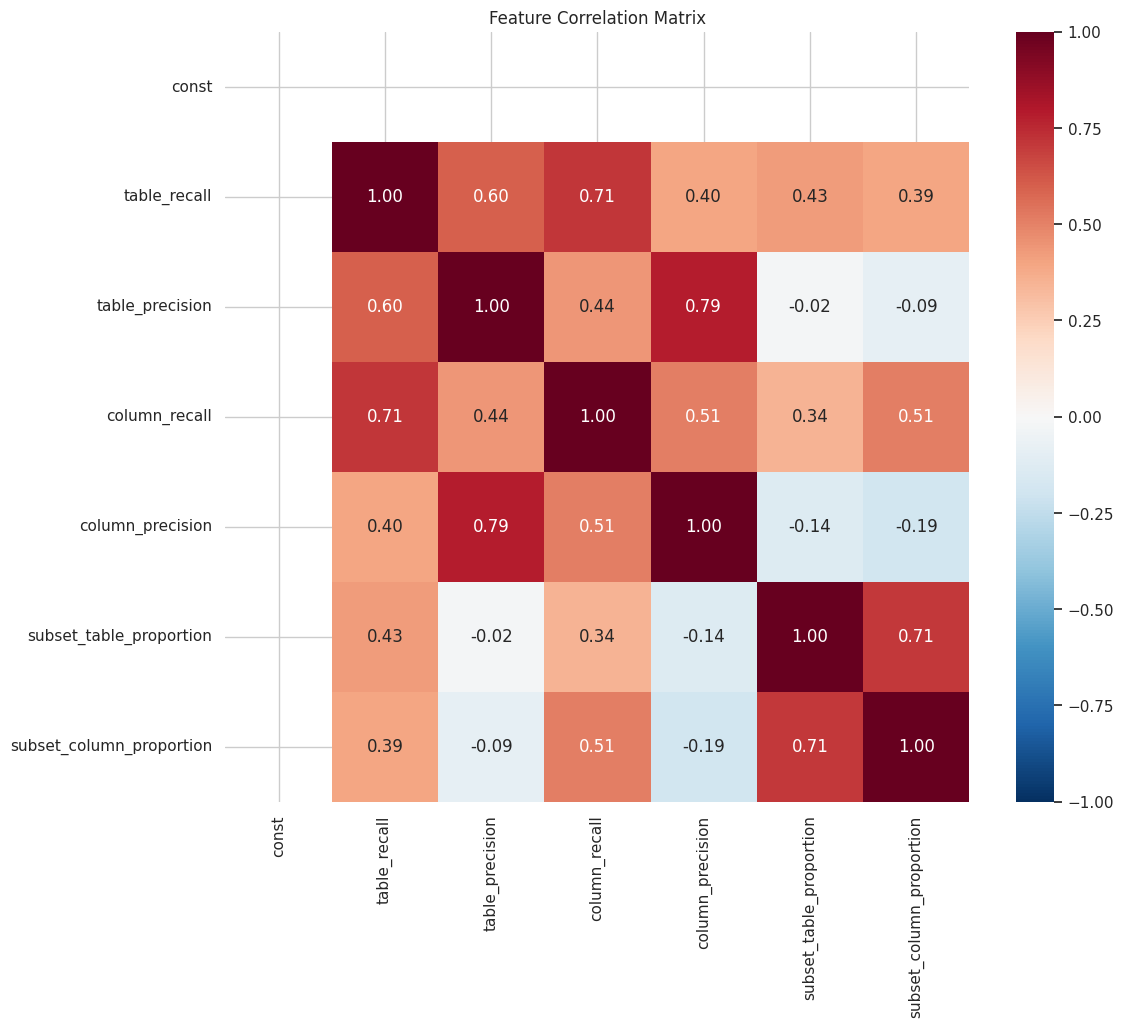

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X_features.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

### Only perfect recall

In [38]:
import statsmodels.api as sm

temp_data_df = subset_performance_df.set_index(
    ["subsetting_method", "benchmark", "database", "question_number"]
    ).join(
        nlsql_performance_df.set_index(
        ["subsetting_method", "benchmark", "database", "question_number"]
        ),
        lsuffix="_l", rsuffix="_r"
    ).reset_index().set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
    ).reset_index().query("perfect_recall == 1 and eval_model_l and has_generated_query").dropna()
temp_data_df['result_set_match_numeric'] = temp_data_df['result_set_match'].astype(int)
temp_data_df["schema_size_numeric"] = temp_data_df.size_cat.apply(lambda x: {
    "s": 1,
    "S": 1,
    "m": 2,
    "M": 2,
    "s-m": 1.5,
    "S-M": 1.5,
    "l": 3,
    "L": 3,
    "l+": 3,
    "L+": 3,
    "xl": 4,
    "XL": 4,
    "xxl": 5,
    "XXL": 5,
    "L-XL-XXL": 4
}[x])

# X = temp_data_df[[
#     "subset_column_count", 
#     "schema_size_numeric"
#     ]]
X = temp_data_df[[
    # "perfect_recall",
    # "total_recall",
    # "total_precision",
    # "total_f1",
    "table_recall",
    "table_precision",
    # "table_f1",
    "column_recall",
    "column_precision",
    # "column_f1",
    "subset_table_proportion",
    "subset_column_proportion",
    # "subset_table_count",
    # "subset_column_count",
    # "schema_size_numeric",
    # "column_count",
    # "rounded_schema_col_count",
    # "LogSchemaColumnCount"
    ]]
y = temp_data_df['result_set_match_numeric']
X = sm.add_constant(X)
logit_model = sm.Logit(y, X).fit()

logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.366248
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                              Logit Regression Results                              
====================================================================================
Dep. Variable:     result_set_match_numeric   No. Observations:                 6062
Model:                                Logit   Df Residuals:                     6056
Method:                                 MLE   Df Model:                            5
Date:                      Mon, 03 Nov 2025   Pseudo R-squ.:                 0.01203
Time:                              14:49:28   Log-Likelihood:                -2220.2
converged:                             True   LL-Null:                       -2247.2
Covariance Type:                  nonrobust   LLR p-value:                 2.030e-10
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
table_recall                -1.1907      0.339     -3.513      0.000      -1.855      -0.526
table_precision              0.4769      0.168      2.833      0.005       0.147       0.807
column_recall               -1.1629      0.301     -3.864      0.000      -1.753      -0.573
column_precision            -0.1004      0.139     -0.721      0.471      -0.373       0.172
subset_table_proportion      0.6677      0.188      3.543      0.000       0.298       1.037
subset_column_proportion    -0.8028      0.224     -3.576      0.000      -1.243      -0.363
============================================================================================
"""

# Token Usage

In [39]:
nlsql_performance_df.subsetting_method.unique()

array(['perfect_subsetter', 'DINSQL', 'chess', 'tasql', 'CodeS', 'dtssql',
       'crush4sql', 'perfect_table_subsetter', 'skalpel', 'nosubset',
       'rslsql'], dtype=object)

/tmp/ipykernel_2354496/1762794676.py:18: RuntimeWarning: divide by zero encountered in log10
  temp_data_df["Log10 Subsetting Prompt Tokens"] = temp_data_df.prompt_tokens.apply(lambda x: np.log10(x))


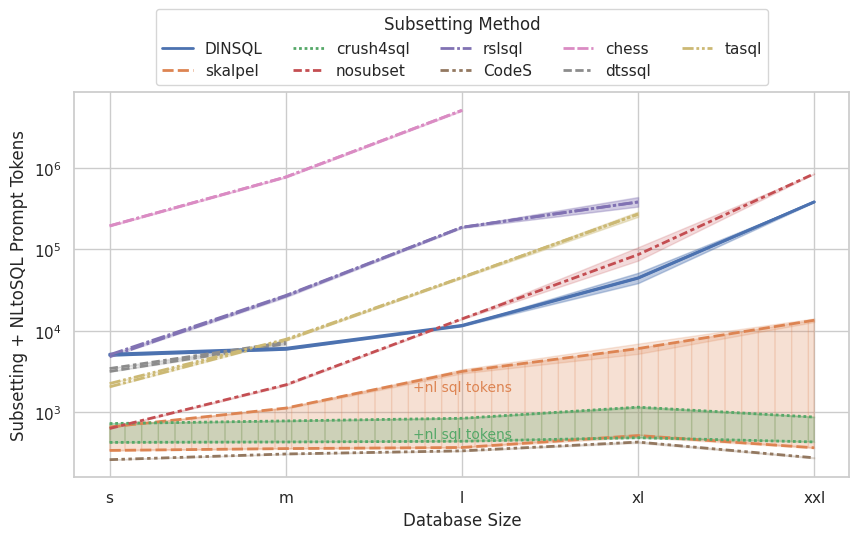

In [40]:
from matplotlib.ticker import FuncFormatter

temp_data_df = subset_performance_df.set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
).reset_index().set_index([
    "subsetting_method", "benchmark", "database", "question_number"
]).rename(columns={"size_cat_expanded": "Database Size"}).join(
    nlsql_performance_df.set_index(["subsetting_method", "benchmark", "database", "question_number"]),
    lsuffix="_l", rsuffix="_r", how="right"
).reset_index().query(
    "(eval_model_l and inference_time>=0 and prompt_tokens>=0 and subsetting_method not in ['perfect_subsetter', 'perfect_table_subsetter']) or subsetting_method=='nosubset'"
    )
temp_data_df["prompt_tokens"] = temp_data_df.prompt_tokens.fillna(0)
temp_data_df["combined_prompt_tokens"] = temp_data_df.apply(
    lambda row: row.prompt_tokens + row.nl_sql_prompt_tokens, 
    axis=1
    )
temp_data_df["Log10 Subsetting Prompt Tokens"] = temp_data_df.prompt_tokens.apply(lambda x: np.log10(x))
temp_data_df["Log10 Nl to SQL Prompt Tokens"] = temp_data_df.nl_sql_prompt_tokens.apply(lambda x: np.log10(x))
temp_data_df["Log10 Combined Prompt Tokens"] = temp_data_df.combined_prompt_tokens.apply(lambda x: np.log10(x))
temp_data_df["Log10ColumnCount"] = temp_data_df.column_count.apply(lambda x: np.log10(x))
plt.figure(figsize=(10, 5))
g = sns.lineplot(
    data=temp_data_df.sort_values(by="size_sort_expanded").rename(columns={
        "subsetting_method": "Subsetting Method"
    }),
    x="Database Size",
    # x="Log10ColumnCount",
    y="Log10 Subsetting Prompt Tokens",
    # y = "Log10 Combined Prompt Tokens",
    # y="nl_sql_prompt_tokens",
    hue="Subsetting Method",
    legend=None,
    style="Subsetting Method",
    linewidth=2
)
g = sns.lineplot(
    data=temp_data_df.sort_values(by="size_sort_expanded").rename(columns={
        "subsetting_method": "Subsetting Method"
    }),
    x="Database Size",
    # x="Log10ColumnCount",
    # y="Log10 Subsetting Prompt Tokens",
    y = "Log10 Combined Prompt Tokens",
    # y="nl_sql_prompt_tokens",
    hue="Subsetting Method",
    legend='full',
    style="Subsetting Method",
    linewidth=2
)
temp_data_df = temp_data_df.sort_values(by="size_sort_expanded")
for subsetting_method in temp_data_df["subsetting_method"].unique():
    if subsetting_method not in ["skalpel", "crush4sql"]:
        continue
    method_df = temp_data_df[temp_data_df["subsetting_method"] == subsetting_method]
    x = method_df["Database Size"].unique()
    y1 = method_df[[
        "Database Size", "size_sort_expanded", "Log10 Subsetting Prompt Tokens"
        ]].groupby("Database Size").mean().reset_index().sort_values(by="size_sort_expanded")["Log10 Subsetting Prompt Tokens"]
    y2 = method_df[[
        "Database Size", "size_sort_expanded", "Log10 Combined Prompt Tokens"
        ]].groupby("Database Size").mean().reset_index().sort_values(by="size_sort_expanded")["Log10 Combined Prompt Tokens"]
    color = g.get_lines()[list(temp_data_df["subsetting_method"].unique()).index(subsetting_method)].get_color()
    plt.fill_between(
        x,
        y1,
        y2,
        color=color,
        alpha=0.25,
        label=f"{subsetting_method} fill",
        hatch="|"
    )
    # Add text labels for the lines
    x_mid = len(x) // 2
    # plt.text(
    #     x[x_mid], 
    #     y1.iloc[x_mid] - 0.001, 
    #     "subsetting", 
    #     color=color, 
    #     fontsize=10, 
    #     ha="center", 
    #     va="top"
    # )
    plt.text(
        x[x_mid], 
        y2.iloc[x_mid] - 0.28, 
        "+nl sql tokens", 
        color=color, 
        fontsize=10, 
        ha="center", 
        va="bottom"
    )
    def log10_exponent_fmt(x, pos):
        return r"$10^{{{}}}$".format(int(x))

    plt.gca().yaxis.set_major_formatter(FuncFormatter(log10_exponent_fmt))
    plt.ylabel("Subsetting + NLtoSQL Prompt Tokens")
sns.move_legend(g, loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=5)
g.figure.savefig("../nl_sql_results/figures/combined_tokens_by_db_size_linechart.pdf", bbox_inches="tight", dpi=300)

/tmp/ipykernel_2354496/4019424865.py:19: RuntimeWarning: divide by zero encountered in log10
  temp_data_df["Log10 Subsetting Prompt Tokens"] = temp_data_df.prompt_tokens.apply(lambda x: np.log10(x))


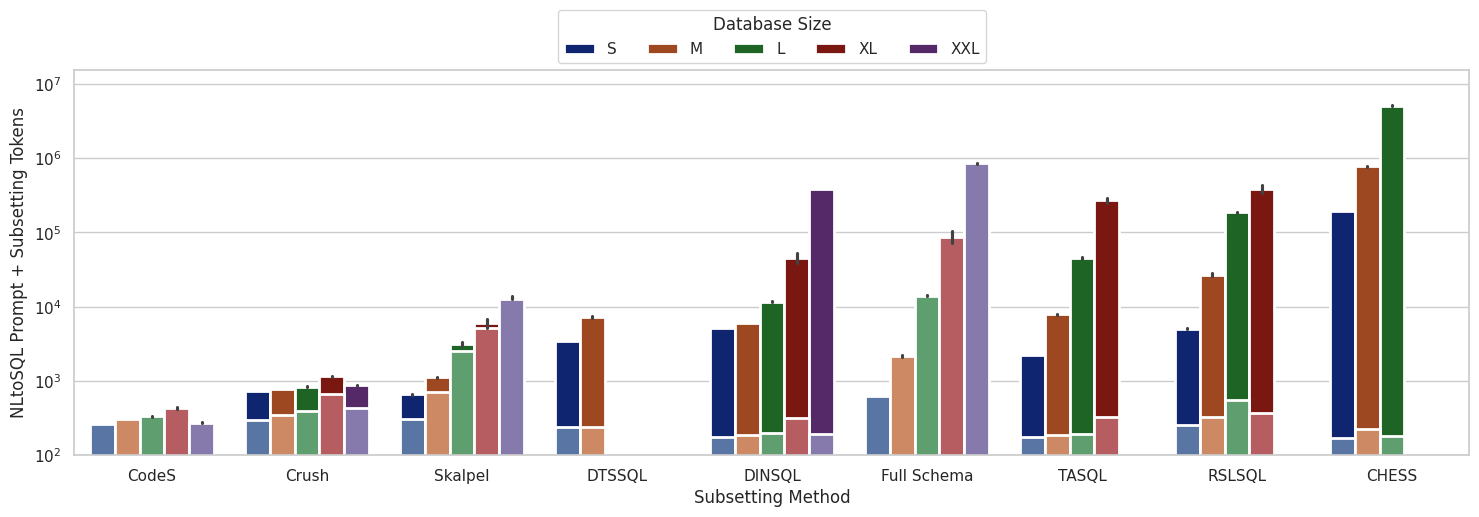

In [41]:
from matplotlib.ticker import FuncFormatter

temp_data_df = subset_performance_df.set_index(["benchmark", "database"]).join(
        schema_stat_df.set_index(["benchmark", "database"])
).reset_index().set_index([
    "subsetting_method", "benchmark", "database", "question_number"
]).rename(columns={"size_cat_expanded": "Database Size"}).join(
    nlsql_performance_df.set_index(["subsetting_method", "benchmark", "database", "question_number"]),
    lsuffix="_l", rsuffix="_r", how="right"
).reset_index().query(
    "(eval_model_l and inference_time>=0 and prompt_tokens>=0 and `Subsetting Method_l` not in ['Perfect', 'Perfect-Table']) or subsetting_method=='nosubset'"
    )
temp_data_df["Database Size"] = temp_data_df["Database Size"].str.upper()
temp_data_df["prompt_tokens"] = temp_data_df.prompt_tokens.fillna(0)
temp_data_df["combined_prompt_tokens"] = temp_data_df.apply(
    lambda row: row.prompt_tokens + row.nl_sql_prompt_tokens, 
    axis=1
    )
temp_data_df["Log10 Subsetting Prompt Tokens"] = temp_data_df.prompt_tokens.apply(lambda x: np.log10(x))
temp_data_df["Log10 Nl to SQL Prompt Tokens"] = temp_data_df.nl_sql_prompt_tokens.apply(lambda x: np.log10(x))
temp_data_df["Log10 Combined Prompt Tokens"] = temp_data_df.combined_prompt_tokens.apply(lambda x: np.log10(x))
temp_data_df["Log10ColumnCount"] = temp_data_df.column_count.apply(lambda x: np.log10(x))
temp_data_df["Subsetting Method"] = temp_data_df.apply(lambda row: "Full Schema" if row.subsetting_method == "nosubset" else row["Subsetting Method_l"], axis=1)
temp_data_df["method_sort"] = temp_data_df["Subsetting Method"].apply(
    lambda x:{
        "CHESS": 900,
        "RSLSQL": 800,
        "TASQL": 700,
        "Full Schema": 600,
        "DINSQL": 500,
        "DTSSQL": 400,
        "Skalpel": 300,
        "Crush": 200,
        "CodeS": 100
    }[x])
plt.figure(figsize=(18, 5))
g = sns.barplot(
    data=temp_data_df.sort_values(by=["size_sort_expanded", "method_sort"]),
    hue="Database Size",
    # x="Log10ColumnCount",
    # y="Log10 Subsetting Prompt Tokens",
    y = "Log10 Combined Prompt Tokens",
    # y="nl_sql_prompt_tokens",
    x="Subsetting Method",
    legend='full',
    linewidth=2,
    palette="dark"
)
g = sns.barplot(
    data=temp_data_df.sort_values(by=["size_sort_expanded", "method_sort"]),
    hue="Database Size",
    # x="Log10ColumnCount",
    y="Log10 Nl to SQL Prompt Tokens",
    # y = "Log10 Combined Prompt Tokens",
    # y="nl_sql_prompt_tokens",
    x="Subsetting Method",
    legend=None,
    linewidth=2,
    errorbar=None
)

# set y-axis to start at 2 (upper bound a bit above the max plotted value)
max_y = temp_data_df[["Log10 Combined Prompt Tokens", "Log10 Nl to SQL Prompt Tokens"]].replace([np.inf, -np.inf], np.nan).max().max()
plt.ylim(2, max_y + 0.2)

def log10_exponent_fmt(x, pos):
    return r"$10^{{{}}}$".format(int(x))

plt.gca().yaxis.set_major_formatter(FuncFormatter(log10_exponent_fmt))
plt.ylabel("NLtoSQL Prompt + Subsetting Tokens")

sns.move_legend(g, loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=5)
g.figure.savefig("../nl_sql_results/figures/combined_tokens_by_db_size_barchart.pdf", bbox_inches="tight", dpi=300)